## Node Classification

In [52]:
# !pip install torch-scatter
# !pip install torch-geometric
# !pip install torch-sparse==0.6.13 -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html

In [53]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GINConv
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Load Dataset:

In [54]:
dataset = Planetoid(root='data/Planetoid', name='Cora',
                    transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [55]:
EPOCHS = 200
HIDDEN_DIM = 64
LEARN_RATE = 0.01

## Implementation using GCN

Network Architecture:

In [56]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, HIDDEN_DIM)
        self.conv2 = GCNConv(HIDDEN_DIM, dataset.num_classes)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

Initialize model, and visualize last layer node embeddings.

C:\Technion\Semester_5\CS 480 - ML code\A3 code\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Technion\Semester_5\CS 480 - ML code\A3 code\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


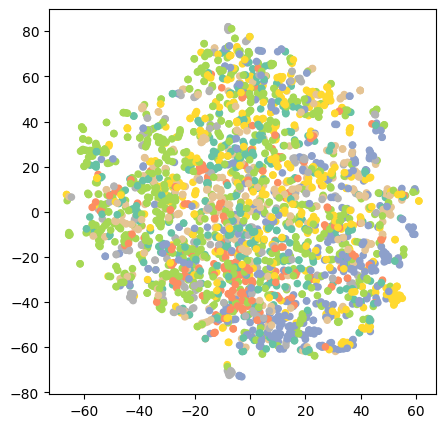

In [57]:
def visualize(emb: torch.tensor, node_type: torch.tensor):
    z = TSNE(n_components=2).fit_transform(emb.detach().cpu().numpy())
    plt.figure(figsize=(5, 5))
    plt.scatter(z[:, 0], z[:, 1], s=20, c=node_type, cmap="Set2")
    plt.show()

model = GCN()
model.eval()
out = model(data)
visualize(out, data.y)

Train and test model:

In [58]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data)
      pred = out.argmax(dim=1)
      train_correct = pred[data.train_mask] == data.y[data.train_mask]
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
      train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
      train_loss.backward()
      optimizer.step()
      return train_loss, train_acc

def test():
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

# dictionary to keep track of losses and accuracies
H = {
	"train_loss": [],
	"train_acc": [],
	"test_acc": [],
    "train_err": [],
	"test_err": [],
}

training_losses = []
for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss, train_acc = train()
    test_acc = test()
    H["train_loss"].append(train_loss.item())
    H["train_acc"].append(train_acc)
    H["test_acc"].append(test_acc)
    H["train_err"].append(1-train_acc)
    H["test_err"].append(1-test_acc)

  0%|          | 0/200 [00:00<?, ?it/s]

Plot errors and losses:

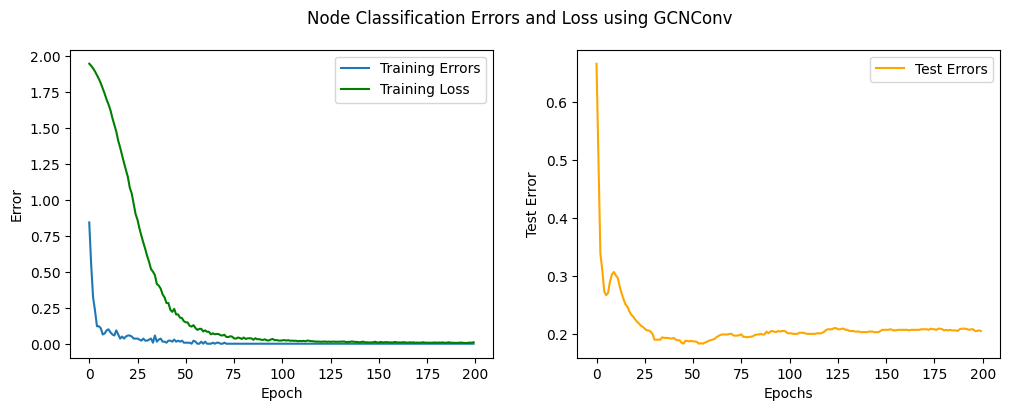

In [59]:
fig = plt.figure(figsize=(12, 4))

sub1 = fig.add_subplot(121)
sub1.plot(H["train_err"], label="Training Errors")
sub1.plot(H["train_loss"], label="Training Loss", color="green")
sub1.set_xlabel("Epoch")
sub1.set_ylabel("Error")
sub1.legend(loc="upper right")

sub2 = fig.add_subplot(122)
sub2.plot(H["test_err"], label='Test Errors', color='orange')
sub2.set_xlabel('Epochs')
sub2.set_ylabel('Test Error')
sub2.legend(loc="upper right")

fig.suptitle('Node Classification Errors and Loss using GCNConv')
plt.show()

Visualize last layer node embedding of the trained model:

C:\Technion\Semester_5\CS 480 - ML code\A3 code\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Technion\Semester_5\CS 480 - ML code\A3 code\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


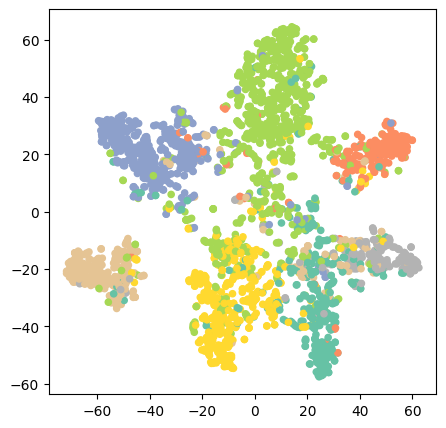

In [60]:
model.eval()
out = model(data)
visualize(out, data.y)

## Implementation using GINConv

Network architecture:

In [61]:
class GIN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(dataset.num_features, HIDDEN_DIM)
        )
        nn2 = torch.nn.Sequential(
            torch.nn.Linear(HIDDEN_DIM, dataset.num_classes)
        )
        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

Training and testing model:

In [62]:
model = GIN()
optimizer = torch.optim.Adam(list(model.parameters()), lr=LEARN_RATE)
criterion = torch.nn.CrossEntropyLoss()

# dictionary to keep track of losses and accuracies
H = {
	"train_loss": [],
	"train_acc": [],
	"test_acc": [],
    "train_err": [],
	"test_err": [],
}

training_losses = []
for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss, train_acc = train()
    test_acc = test()
    H["train_loss"].append(train_loss.item())
    H["train_acc"].append(train_acc)
    H["test_acc"].append(test_acc)
    H["train_err"].append(1-train_acc)
    H["test_err"].append(1-test_acc)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 001, Acc: 0.1071 Loss: 1.9598, Test Acc: 0.3120
Epoch: 002, Acc: 0.3929 Loss: 1.7627, Test Acc: 0.4470
Epoch: 003, Acc: 0.6357 Loss: 1.5199, Test Acc: 0.5960
Epoch: 004, Acc: 0.7286 Loss: 1.3410, Test Acc: 0.7310
Epoch: 005, Acc: 0.8286 Loss: 1.2004, Test Acc: 0.7740
Epoch: 006, Acc: 0.8714 Loss: 1.0435, Test Acc: 0.7810
Epoch: 007, Acc: 0.8714 Loss: 0.9136, Test Acc: 0.7820
Epoch: 008, Acc: 0.8857 Loss: 0.8247, Test Acc: 0.7760
Epoch: 009, Acc: 0.8786 Loss: 0.7011, Test Acc: 0.7660
Epoch: 010, Acc: 0.9214 Loss: 0.6253, Test Acc: 0.7430
Epoch: 011, Acc: 0.8643 Loss: 0.6954, Test Acc: 0.7450
Epoch: 012, Acc: 0.9071 Loss: 0.5180, Test Acc: 0.7530
Epoch: 013, Acc: 0.9357 Loss: 0.4328, Test Acc: 0.7490
Epoch: 014, Acc: 0.9429 Loss: 0.3935, Test Acc: 0.7540
Epoch: 015, Acc: 0.9643 Loss: 0.3500, Test Acc: 0.7540
Epoch: 016, Acc: 0.9786 Loss: 0.3871, Test Acc: 0.7630
Epoch: 017, Acc: 0.9571 Loss: 0.3953, Test Acc: 0.7600
Epoch: 018, Acc: 0.9786 Loss: 0.2510, Test Acc: 0.7630
Epoch: 019

Plotting results:

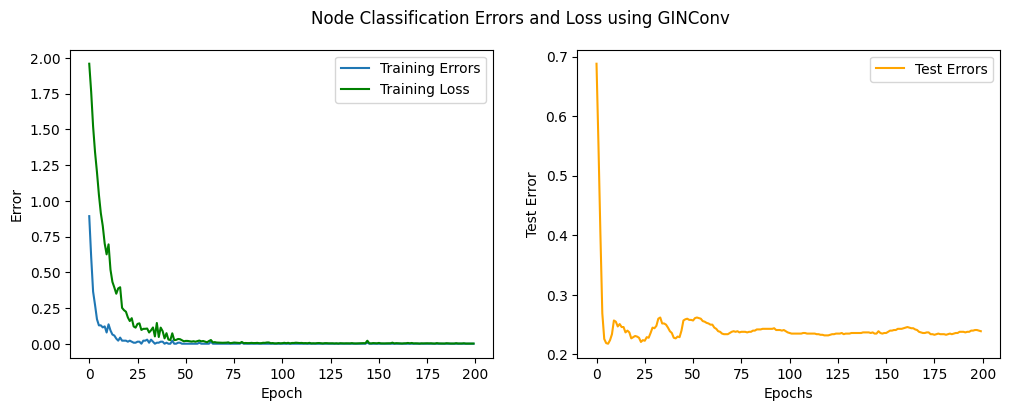

In [63]:
fig = plt.figure(figsize=(12, 4))

sub1 = fig.add_subplot(121)
sub1.plot(H["train_err"], label="Training Errors")
sub1.plot(H["train_loss"], label="Training Loss", color="green")
sub1.set_xlabel("Epoch")
sub1.set_ylabel("Error")
sub1.legend(loc="upper right")

sub2 = fig.add_subplot(122)
sub2.plot(H["test_err"], label='Test Errors', color='orange')
sub2.set_xlabel('Epochs')
sub2.set_ylabel('Test Error')
sub2.legend(loc="upper right")

fig.suptitle('Node Classification Errors and Loss using GINConv')
plt.show()

Visualize last layer node embedding of the trained model:


C:\Technion\Semester_5\CS 480 - ML code\A3 code\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Technion\Semester_5\CS 480 - ML code\A3 code\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


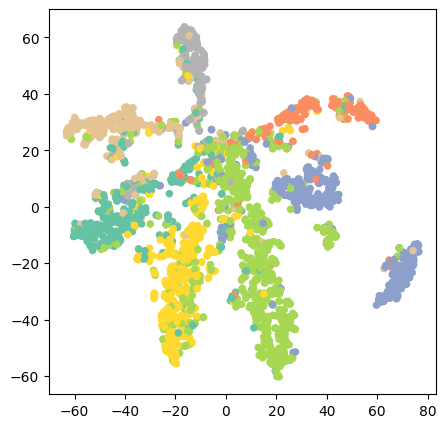

In [64]:
model.eval()
out = model(data)
visualize(out, data.y)